In [1]:
%matplotlib inline
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_data_dir = '../data_scaled/'
validation_data_dir = 'data_scaled_validation/'

Using TensorFlow backend.


In [2]:
# %load "../src/sandbox/ml_lib/moleimages.py"
import numpy as np
from skimage import io
from skimage.transform import resize

import matplotlib.pyplot as plt
import glob
import h5py

import os


class MoleImages():
    def __init__(self, dir=None):
        self.dir = dir
        self.size = None

    def resize_bulk(self, size=(128,128)):
        '''
        Resize Images and create matrix
        Input: size of the images (128,128)
        Output: Numpy array of (size,num_images)
        '''

        print(os.getcwd())

        self.size = size
        X = []
        image_list = glob.glob(self.dir)
        n_images = len(image_list)
        print('Resizing {} images:'.format(n_images))
        for i, imgfile in enumerate(image_list):
            print('Resizing image {} of {}'.format(i+1, n_images))
            img = io.imread(imgfile)
            img = resize(img, self.size)
            X.append(img)
        return np.array(X)

    def load_test_images(self, dir_b, dir_m):
        X = []
        image_list_b = glob.glob(dir_b + '/*.png')
        n_images_b = len(image_list_b)
        print('Loading {} images of class benign:'.format(n_images_b))
        for i, imgfile in enumerate(image_list_b):
            #print('Loading image {} of {}'.format(i+1, n_images_b))
            img = io.imread(imgfile)
            X.append(img)
        image_list_m = glob.glob(dir_m + '/*.png')
        n_images_m = len(image_list_m)
        print('Loading {} images of class malign:'.format(n_images_m))
        for i, imgfile in enumerate(image_list_m):
            #print('Loading image {} of {}'.format(i+1, n_images_m))
            img = io.imread(imgfile)
            X.append(img)
        y = np.hstack((np.zeros(n_images_b), np.ones(n_images_m)))

        return np.array(X), y.reshape(len(y),1)

    def load_image(self, filename, size=(128,128)):
        self.size = size
        img = io.imread(filename)
        img = resize(img, self.size, mode='constant') * 255
        if img.shape[2] == 4:
            img = img[:,:,0:3]
        return img.reshape(1, self.size[0], self.size[1], 3)

    def save_h5(self, X, filename, dataset):
        '''
        Save a numpy array to a data.h5 file specified.
        Input:
        X: Numpy array to save
        filename: name of h5 file
        dataset: label for the dataset
        '''
        with h5py.File(filename, 'w') as hf:
            hf.create_dataset(dataset, data=X)
        print('File {} saved'.format(filename))

    def load_h5(self, filename, dataset):
        '''
        Load a data.h5 file specified.
        Input: filename, dataset
        Output: Data
        '''
        with h5py.File(filename, 'r') as hf:
            return hf[dataset][:]

    def save_png(self, matrix, dir, tag='img', format='png'):
        for i, img in enumerate(matrix):
            if dir[-1] != '/':
                filename = dir + '/' + tag + str(i) + '.' + format
            else:
                filename = dir + tag + str(i) + '.' + format
            print('Saving file {}'.format(filename))
            io.imsave(filename, img)



In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05
)
mimg = MoleImages()
X_test, y_test = mimg.load_test_images('../data_scaled_validation/benign', '../data_scaled_validation/malign')

Loading 120 images of class benign:
Loading 84 images of class malign:


In [37]:
#train_gen = train_datagen.flow_from_directory(train_data_dir, target_size=(128,128), batch_size=1)
train_gen = train_datagen.flow(X_test, y_test, batch_size=3, shuffle=False)

(3, 128, 128, 3)


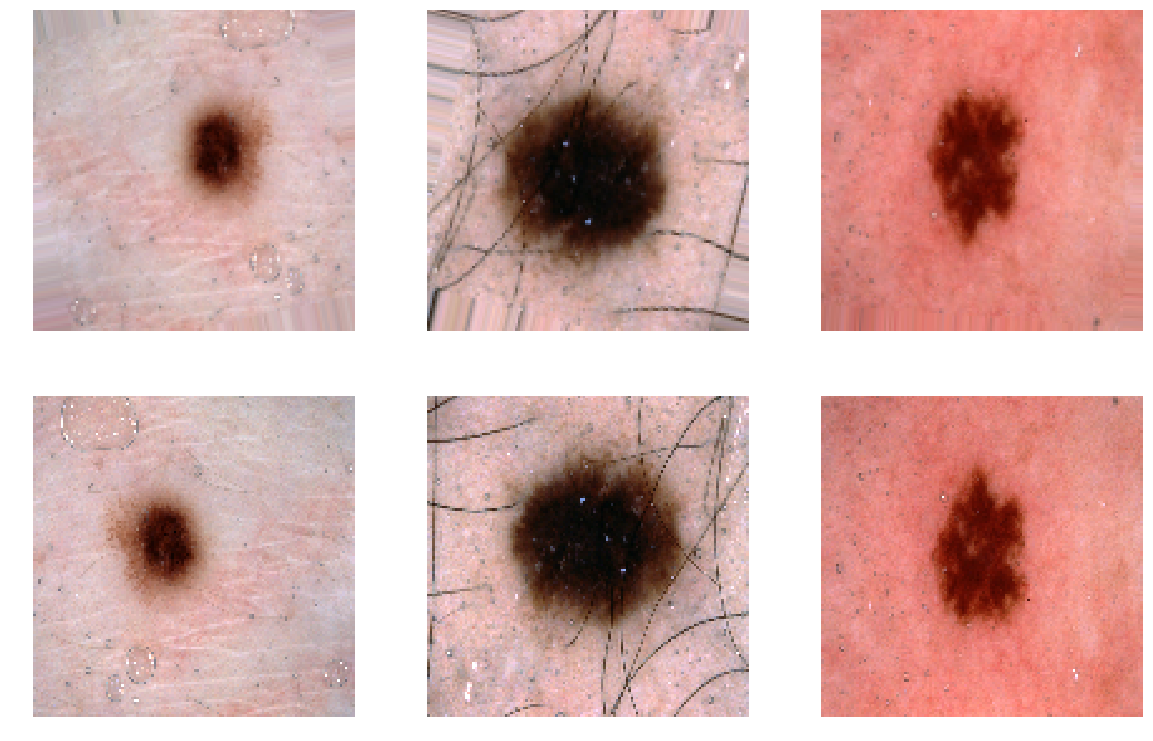

In [38]:
images = train_gen.next()[0]
print(images.shape)

f, axarr = plt.subplots(2,len(images))
f.set_figwidth(20)
f.set_figheight(13)
for i in range(len(images)):
    axarr[0, i].imshow(images[i].astype("uint8"))
    axarr[0,i].axis("off")
    axarr[1, i].imshow(X_test[i])
    axarr[1,i].axis("off")